In [1]:
################################################################################################################################
#
# ECONOMETRIC - ROLLING - LN - MONTHLY - ARMA FracDiff
#
################################################################################################################################

In [2]:
#===============================================================================================================================
# ENVIRONMENT: LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pmdarima as pmd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
seriesId='IBOV-FracDiff-Ln-Monthly'
df = pd.read_csv('Data/Input/'+seriesId+'.csv')
#df.drop(['Open','Low','High', 'Qt'], axis='columns', inplace=True )
PERIOD=12
df

,Date,Close
0,2006-01-31,3.917126
1,2006-02-24,3.881832
2,2006-03-31,3.842665
3,2006-04-28,3.892926
4,2006-05-31,3.770014
...,...,...
211,2023-08-31,4.087320
212,2023-09-29,4.097383
213,2023-10-31,4.065104
214,2023-11-30,4.187422


In [4]:
#===============================================================================================================================
# DATA: DATETIME
#===============================================================================================================================
df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)

C:\Users\55119\AppData\Local\Temp\ipykernel_16756\2143690635.py:4: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] =pd.to_datetime(df['Date'], dayfirst=True)


In [5]:
#===============================================================================================================================
# DATA: SET INDEX
#===============================================================================================================================
df2 = df.set_index('Date')

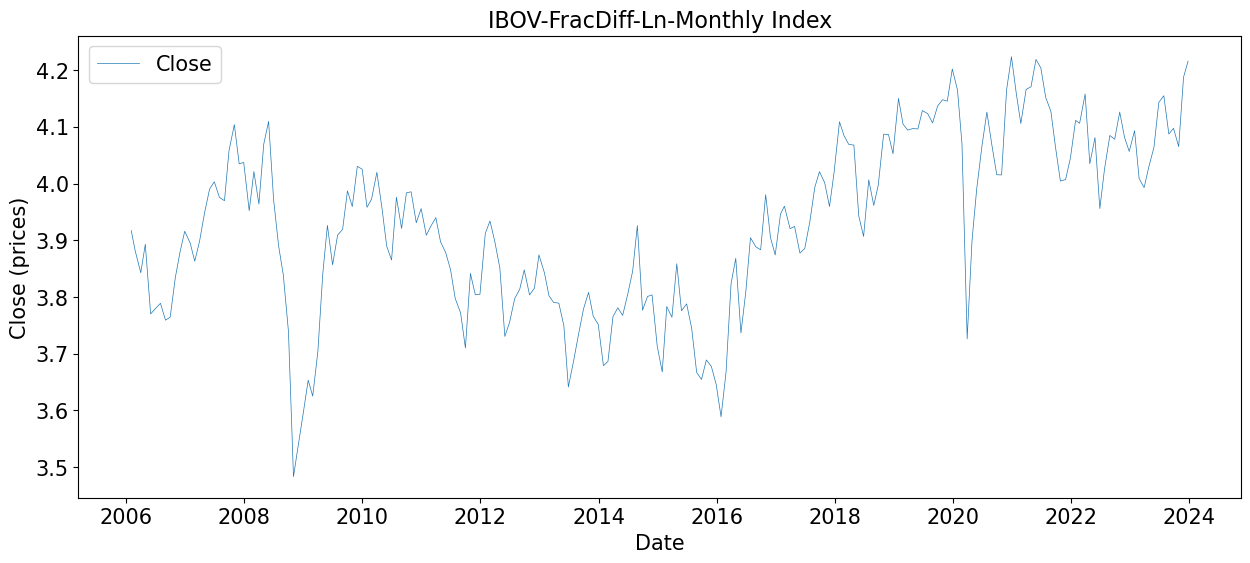

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(df['Date'], df['Close'], label = "Close", linewidth=0.5)
plt.title(seriesId+' Index', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close (prices)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()

In [7]:
#===============================================================================================================================
# DATA: LOG
#===============================================================================================================================
dfln = df.copy()
#dfln['CloseLn']= np.log(dfln['Close'])
dfln['CloseLn']= dfln['Close']

In [8]:
#===============================================================================================================================
# DATA: LOG - SET INDEX
#===============================================================================================================================
dfln2 = dfln.set_index('Date')

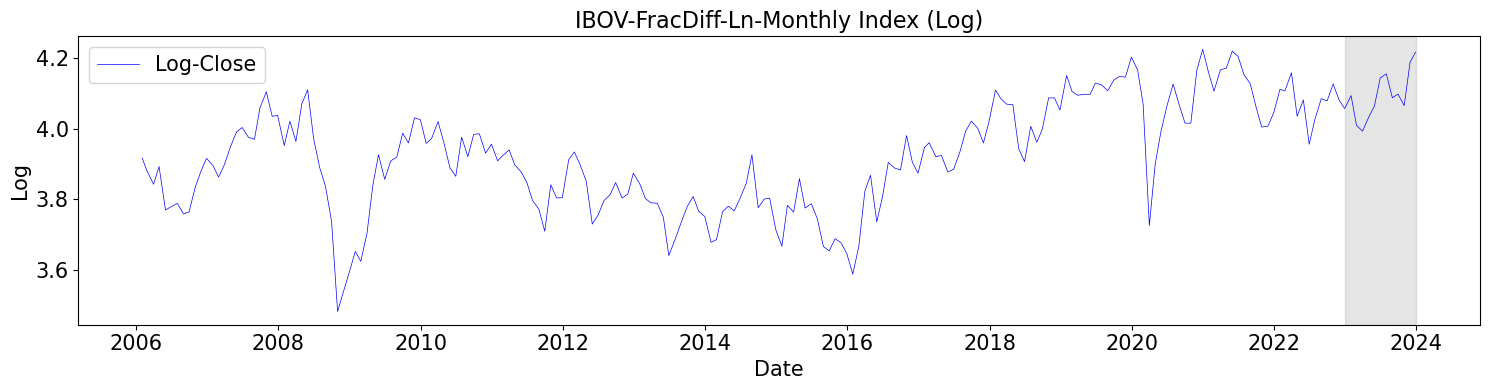

In [9]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
plt.figure(figsize=(15,4))
plt.plot(dfln['Date'], dfln['CloseLn'], 'b-', label = "Log-Close", linewidth=0.5)
plt.title(seriesId+' Index (Log)', fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Log', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.tight_layout()
plt.show()

In [10]:
#===============================================================================================================================
# DATA: LOG-DIFF
#===============================================================================================================================
dfln['CloseLnDiff'] = 0
dfln.loc[1:, ['CloseLnDiff']] = dfln.loc[:, 'CloseLn'].diff()

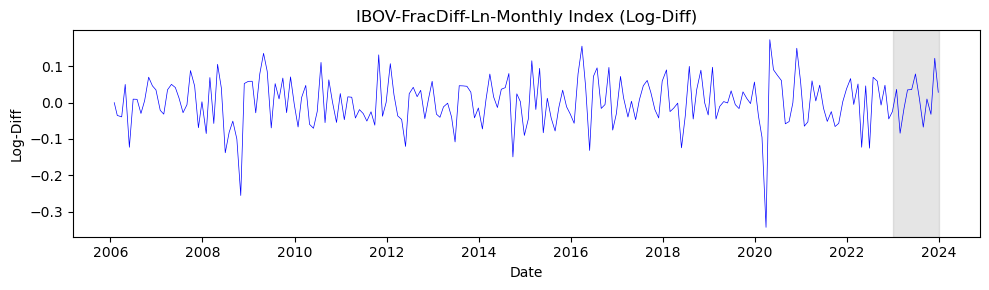

In [11]:
#===============================================================================================================================
# DATA: LOG-DIFF - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10, 3))
plt.title(seriesId+' Index (Log-Diff)', fontsize=12)
ax.plot(dfln['Date'], dfln['CloseLnDiff'], 'b-', label = "Log-Diff Close", linewidth=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Log-Diff')
ax.axvspan('2023', '2024', color='#808080', alpha=0.2)
plt.tight_layout()

In [12]:
#===============================================================================================================================
# DATA: SPLIT
#===============================================================================================================================
totallen = len(df)
trainlen = len(df2[:'2022'])
testlen  = len(df2['2023':])

trainfin = trainlen-1
testini  = trainlen

train = df[:testini]
test  = df[testini:]

print("Train Len", trainlen, "Length Total =", totallen, "| Train Fin =", trainfin, "| Test Ini =", testini)
#-------------------------------------------------------------------------------------------------------------------------------
# Train Len 204 Length Total = 216 | Train Fin = 203 | Test Ini = 204
#-------------------------------------------------------------------------------------------------------------------------------

Train Len 204 Length Total = 216 | Train Fin = 203 | Test Ini = 204


In [13]:
################################################################################################################################
# ROLLING FORECAST
################################################################################################################################
from statsmodels.tsa.statespace.sarimax import SARIMAX

#===============================================================================================================================
# ROLLING FORECAST: PARAMETERS
#===============================================================================================================================
HORIZON = len(test)
WINDOW = 1

#===============================================================================================================================
# ROLLING FORECAST: FUNCTION
#===============================================================================================================================
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, orderparam=(0,0,0)) -> list:   
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    elif method == 'last':
        pred_last = []
        
        for i in range(train_len, total_len, window):
            last = df.loc[i]
            pred_last.extend(last for _ in range(window))
        return pred_last
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ1 = {}, θ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_MA
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("phi1 = {}, phi2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_AR
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=orderparam)  
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        model_fit = model.fit(disp=False)
        print(model_fit.summary())
        print("θ = {}, σ2 = {}".format(model_fit.params[0],model_fit.params[1]))
        return pred_ARMA

In [14]:
################################################################################################################################
# BASELINES
################################################################################################################################

In [15]:
#===============================================================================================================================
# BASELINES: LOG - FORECAST - last, mean
#===============================================================================================================================
pred_LastLn = rolling_forecast(dfln['CloseLn'], trainfin, HORIZON, WINDOW, 'last')

#===============================================================================================================================
# BASELINES: LOG - COPY testln - last, mean 
#===============================================================================================================================
testln = dfln.loc[trainfin:,['Date','CloseLn']]
testln.loc[testini:,'pred_LastLn'] = pred_LastLn
testln

,Date,CloseLn,pred_LastLn
203,2022-12-29,4.056669,NaN
204,2023-01-31,4.093338,4.056669
205,2023-02-28,4.009027,4.093338
206,2023-03-31,3.992839,4.009027
207,2023-04-28,4.028022,3.992839
208,2023-05-31,4.064120,4.028022
209,2023-06-30,4.143223,4.064120
210,2023-07-31,4.154807,4.143223
211,2023-08-31,4.087320,4.154807
212,2023-09-29,4.097383,4.087320


In [16]:
#===============================================================================================================================
# BASELINES: LOG - COPY dfln - last, mean 
#===============================================================================================================================
dfln['pred_LastLn'] = 0.0
dfln.loc[testini:,'pred_LastLn']=testln.loc[testini:,'pred_LastLn']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn
203,2022-12-29,4.056669,4.056669,-0.024598,0.000000
204,2023-01-31,4.093338,4.093338,0.036669,4.056669
205,2023-02-28,4.009027,4.009027,-0.084311,4.093338
206,2023-03-31,3.992839,3.992839,-0.016189,4.009027
207,2023-04-28,4.028022,4.028022,0.035183,3.992839
208,2023-05-31,4.064120,4.064120,0.036099,4.028022
209,2023-06-30,4.143223,4.143223,0.079102,4.064120
210,2023-07-31,4.154807,4.154807,0.011585,4.143223
211,2023-08-31,4.087320,4.087320,-0.067487,4.154807
212,2023-09-29,4.097383,4.097383,0.010063,4.087320


In [17]:
#===============================================================================================================================
# BASELINES: LOG - PERFORMANCE
#===============================================================================================================================
mse_Last   = mean_squared_error(dfln.loc[testini:,'CloseLn'], dfln.loc[testini:,'pred_LastLn'])
data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))]]
df_metrics   = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,Last,0.0033,0.0571


Text(0, 0.5, 'Log')

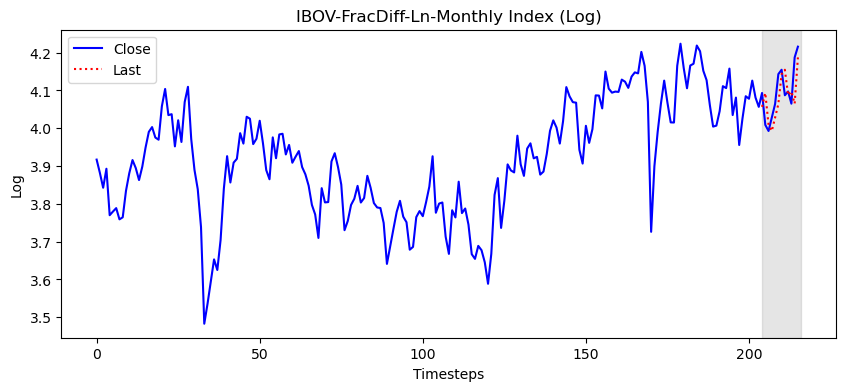

In [18]:
#===============================================================================================================================
# BASELINES: LOG - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln['CloseLn'], 'b-', label='Close')
ax3.plot(dfln.loc[testini:,'pred_LastLn'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

Text(0, 0.5, 'Log')

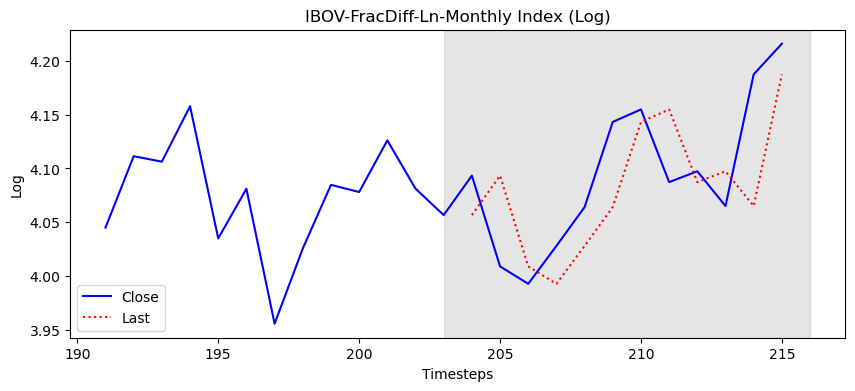

In [19]:
#===============================================================================================================================
# BASELINES: LOG - Plot (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Log)', fontsize=12)
ax3.plot(dfln.loc[trainfin-testlen:,'CloseLn'    ], 'b-', label='Close')
ax3.plot(dfln.loc[testini:  ,'pred_LastLn'], 'r:', label='Last')
ax3.axvspan(trainfin, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=3)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Log')

In [20]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER
#===============================================================================================================================
df['pred_Last'] = 0.0
pred_Last = rolling_forecast(dfln['Close'], trainfin, HORIZON, WINDOW, 'last')
df.loc[testini:,'pred_Last']= pred_Last


In [21]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PERFORMANCE
#===============================================================================================================================
mse_Last = mean_squared_error(df.loc[testini:,'Close'], df.loc[testini:,'pred_Last'])
data_metrics = [['Last'  , "{:,}".format(round(mse_Last,4))  , "{:,}".format(round(sqrt(mse_Last),4))] ]

df_metrics   = pd.DataFrame(data_metrics, columns=['Price', 'MSE', 'RMSE'])
df_metrics

,Price,MSE,RMSE
0,Last,0.0033,0.0571


Text(0, 0.5, 'Prices')

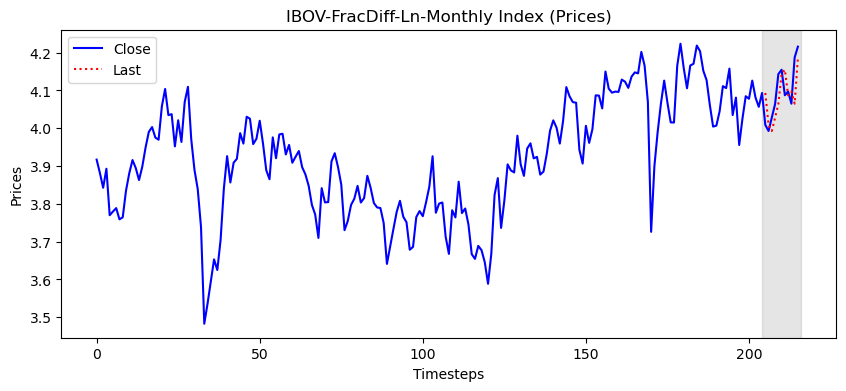

In [22]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df['Close'], 'b-', label='Close')
ax3.plot(df.loc[testini+1:,'pred_Last'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

Text(0, 0.5, 'Prices')

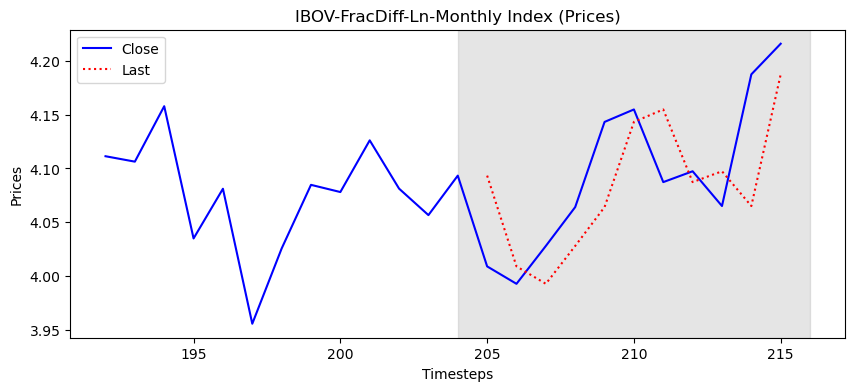

In [23]:
#===============================================================================================================================
# BASELINES: PRICES - RECOVER - PLOT (zoom)
#===============================================================================================================================
fig, (ax3) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10, 4))

plt.title(seriesId+' Index (Prices)', fontsize=12)
ax3.plot(df.loc[testini-testlen:,'Close'    ], 'b-', label='Close')
ax3.plot(df.loc[testini+1:  ,'pred_Last'], 'r:', label='Last')
ax3.axvspan(testini, totallen, color='#808080', alpha=0.2)
ax3.legend(loc=2)
ax3.set_xlabel('Timesteps')
ax3.set_ylabel('Prices')

In [24]:
################################################################################################################################
# STATIONARITY
################################################################################################################################

#===============================================================================================================================
# STATIONARITY: LOG - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLn'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')

#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -3.004
# ADF p-value  : 0.03 < 0.05
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -3.004
ADF p-value  : 0.03


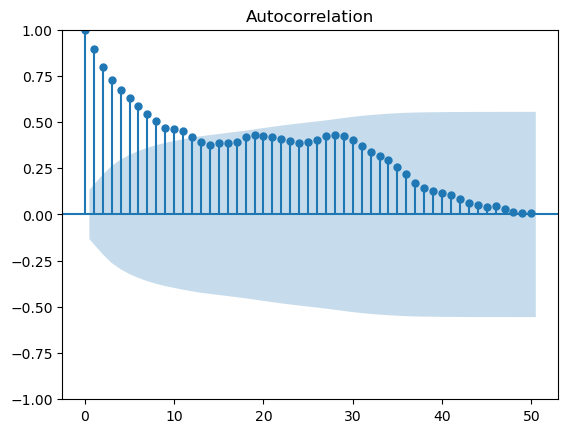

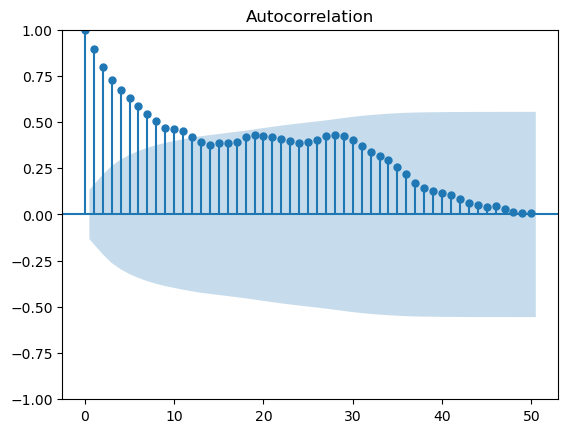

In [25]:
#===============================================================================================================================
# STATIONARITY: LOG - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLn'], lags=50)

#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients slowly decreasing after lag 0 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION present ******
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM-WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [26]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ADF test
#===============================================================================================================================
ADF_Close = adfuller(dfln['CloseLnDiff'])
print(f'ADF Statistic: {np.round(ADF_Close[0],3)}')
print(f'ADF p-value  : {np.round(ADF_Close[1],2)}')
#-------------------------------------------------------------------------------------------------------------------------------
# ADF Statistic: -11.817
# ADF p-value  : 0.0
# Null hypothesis rejected - No Unit Root
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF Statistic: -11.817
ADF p-value  : 0.0


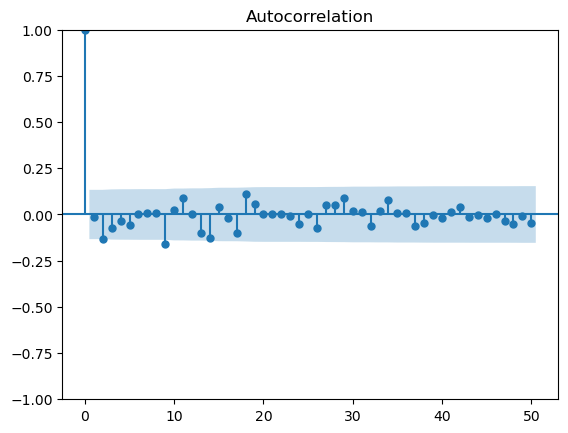

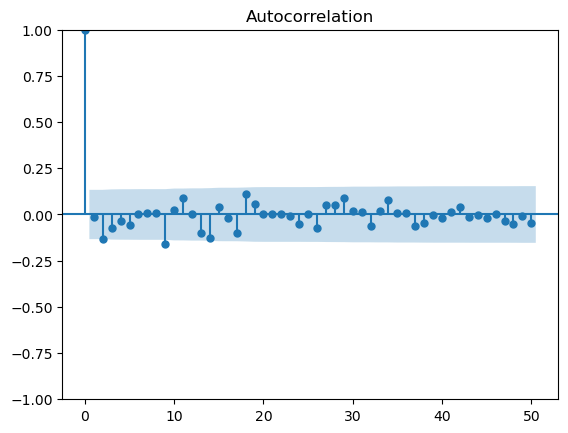

In [27]:
#===============================================================================================================================
# STATIONARITY: LOG-DIFF - ACF plot
#===============================================================================================================================
plot_acf(dfln['CloseLnDiff'], lags=50)
#-------------------------------------------------------------------------------------------------------------------------------
# Significant AC coefficients after lag 0: 0* 
#-------------------------------------------------------------------------------------------------------------------------------
# ***** AUTOCORRELATION *****
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# DATA STATIONARITY: LOG-DIFF - ADF test + ACF plot
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# ***** NO RANDOM WALK *****
#-------------------------------------------------------------------------------------------------------------------------------

In [28]:
################################################################################################################################
#
# ARMA
#
################################################################################################################################

In [29]:
#===============================================================================================================================
# ARMA: OPTIMIZE Function - AIC (Akaike Information Criterion)
#===============================================================================================================================
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    
    results = []
    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
             continue
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [41]:
#===============================================================================================================================
# ARMA: TRAIN SET
#===============================================================================================================================
train = df.Close[:trainfin+1]
trainLn = dfln.CloseLn[:trainfin+1]
trainLnDiff = dfln.CloseLnDiff[:trainfin+1]
dfln

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn
0,2006-01-31,3.917126,3.917126,0.000000,0.000000
1,2006-02-24,3.881832,3.881832,-0.035294,0.000000
2,2006-03-31,3.842665,3.842665,-0.039166,0.000000
3,2006-04-28,3.892926,3.892926,0.050261,0.000000
4,2006-05-31,3.770014,3.770014,-0.122912,0.000000
...,...,...,...,...,...
211,2023-08-31,4.087320,4.087320,-0.067487,4.154807
212,2023-09-29,4.097383,4.097383,0.010063,4.087320
213,2023-10-31,4.065104,4.065104,-0.032279,4.097383
214,2023-11-30,4.187422,4.187422,0.122318,4.065104


In [31]:
#===============================================================================================================================
# ARMA: PARAMETERS ps, qs
#===============================================================================================================================
from itertools import product
ps = range(0, 4, 1)    
qs = range(0, 4, 1)     

order_list = list(product(ps, qs))
len(order_list)

16

In [39]:
#===============================================================================================================================
# ARMA: Optimize_ARMA - AIC
#===============================================================================================================================
#result_df = optimize_ARMA(trainLn, order_list) 
#result_df
#-----------------------
#    (p,q) AIC
#-----------------------
# 0 (1, 3) -507.586218
# 1 (1, 2) -507.410512
# 2 (1, 0) -506.936113
# 3 (3, 0) -506.733250
# 4 (1, 1) -505.002267
# 5 (2, 0) -504.984122

In [33]:
#===============================================================================================================================
# ARMA: LOG - FORECAST
#===============================================================================================================================
pred_ARMALn = rolling_forecast(dfln['CloseLn'], testini, HORIZON, WINDOW, 'ARMA',(1,0,0))

'''
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                  215
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 270.788
Date:                Mon, 02 Dec 2024   AIC                           -537.576
Time:                        19:39:00   BIC                           -530.835
Sample:                             0   HQIC                          -534.852
                                - 215                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001    837.731      0.000       0.998       1.002
sigma2         0.0045      0.000     15.490      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               104.31
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                            -0.76
Prob(H) (two-sided):                  0.37   Kurtosis:                         6.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9998616515700953, σ2 = 0.0045401424492581876

                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                  215
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 273.200
Date:                Mon, 02 Dec 2024   AIC                           -538.400
Time:                        19:46:24   BIC                           -524.918
Sample:                             0   HQIC                          -532.953
                                - 215                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001   1066.030      0.000       0.998       1.002
ma.L1         -0.0552      0.057     -0.967      0.334      -0.167       0.057
ma.L2         -0.1602      0.077     -2.071      0.038      -0.312      -0.009
sigma2         0.0044      0.000     15.217      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               166.08
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.96
Prob(H) (two-sided):                  0.58   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9999161311161645, σ2 = -0.055241870827673255

                               SARIMAX Results                                
==============================================================================
Dep. Variable:                CloseLn   No. Observations:                  215
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 274.378
Date:                Mon, 02 Dec 2024   AIC                           -538.757
Time:                        19:47:23   BIC                           -521.903
Sample:                             0   HQIC                          -531.947
                                - 215                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001   1282.961      0.000       0.998       1.001
ma.L1         -0.0517      0.061     -0.851      0.395      -0.171       0.067
ma.L2         -0.1739      0.081     -2.144      0.032      -0.333      -0.015
ma.L3         -0.1117      0.074     -1.504      0.133      -0.257       0.034
sigma2         0.0044      0.000     14.522      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               168.80
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -0.98
Prob(H) (two-sided):                  0.75   Kurtosis:                         6.87
===================================================================================
Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
θ = 0.9999405282459167, σ2 = -0.051665100913422864

'''

C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\55119\anacond

                               SARIMAX Results                                
Dep. Variable:                CloseLn   No. Observations:                  215
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 274.378
Date:                Tue, 03 Dec 2024   AIC                           -538.757
Time:                        12:37:02   BIC                           -521.903
Sample:                             0   HQIC                          -531.947
                                - 215                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.001   1282.961      0.000       0.998       1.001
ma.L1         -0.0517      0.061     -0.851      0.395      -0.171       0.067
ma.L2         -0.1739      0.081     -2.144      0.0

'\n                               SARIMAX Results                                \n==============================================================================\nDep. Variable:                CloseLn   No. Observations:                  215\nModel:               SARIMAX(1, 0, 0)   Log Likelihood                 270.788\nDate:                Mon, 02 Dec 2024   AIC                           -537.576\nTime:                        19:39:00   BIC                           -530.835\nSample:                             0   HQIC                          -534.852\n                                - 215                                         \nCovariance Type:                  opg                                         \n==============================================================================\n                 coef    std err          z      P>|z|      [0.025      0.975]\n------------------------------------------------------------------------------\nar.L1          0.9999      0.001    8

In [34]:
#===============================================================================================================================
# ARMA: LOG - STORE PRED, SAVE EXCEL
#===============================================================================================================================
testln.loc[testini:,'pred_ARMALn'] = 0
testln.loc[testini:,'pred_ARMALn'] = pred_ARMALn
testln.loc[testini:,'pred_ARMALn'].to_excel('Data/Output/Rolling-Ln-Monthly-ARMA FracDiff-ARMALn.xlsx')
testln

,Date,CloseLn,pred_LastLn,pred_ARMALn
203,2022-12-29,4.056669,NaN,NaN
204,2023-01-31,4.093338,4.056669,4.056839
205,2023-02-28,4.009027,4.093338,4.098464
206,2023-03-31,3.992839,4.009027,4.008533
207,2023-04-28,4.028022,3.992839,4.005007
208,2023-05-31,4.064120,4.028022,4.038619
209,2023-06-30,4.143223,4.064120,4.060317
210,2023-07-31,4.154807,4.143223,4.132233
211,2023-08-31,4.087320,4.154807,4.136351
212,2023-09-29,4.097383,4.087320,4.076136


In [35]:
#===============================================================================================================================
# ARMA: LOG - PERFORMANCE
#===============================================================================================================================
mse_ARMA   = mean_squared_error(dfln.loc[testini:,'CloseLn'], testln.loc[testini:,'pred_ARMALn'])
data_metrics = [['ARMA'  , "{:,}".format(round(mse_ARMA,6))  , "{:,}".format(round(sqrt(mse_ARMA),6))] ]

df_metrics = pd.DataFrame(data_metrics, columns=['Log', 'MSE', 'RMSE'])
df_metrics

,Log,MSE,RMSE
0,ARMA,0.003132,0.055963


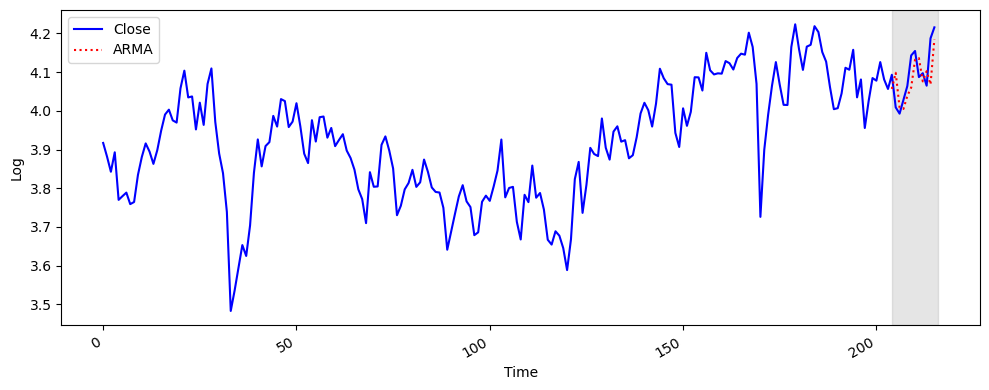

In [36]:
#===============================================================================================================================
# ARMA: LOG - PLOT
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln['CloseLn']      , 'b-' , label='Close')
ax.plot(testln['pred_ARMALn'], 'r:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
#plt.xticks(np.arange(0, totallen, testlen), np.arange(2000, 2024, 1))
fig.autofmt_xdate()
plt.tight_layout()


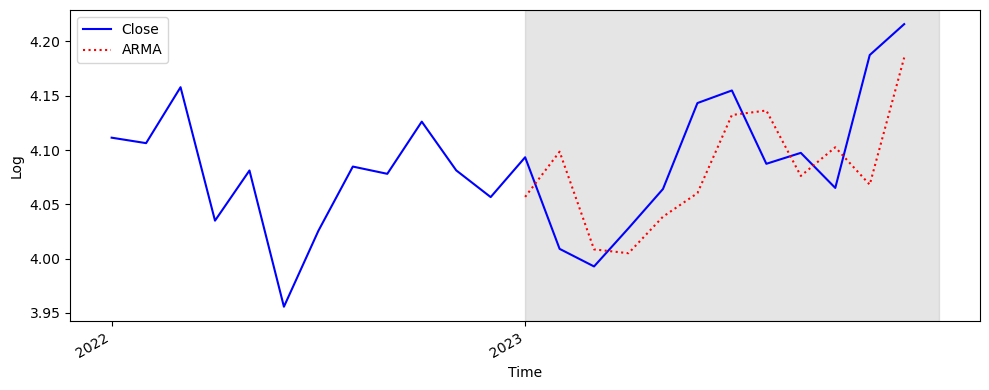

In [37]:
#===============================================================================================================================
# ARMA: LOG - PLOT (zoom)
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(dfln.loc[testini-testlen:,'CloseLn'], 'b-' , label='Close')
ax.plot(testln.loc[-testlen:,'pred_ARMALn'] , 'r:' , label='ARMA')
ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Log')
ax.axvspan(testini, totallen, color='#808080', alpha=0.2)
plt.xticks(np.arange(testini-testlen, totallen, testlen), [2022, 2023])
fig.autofmt_xdate()
plt.tight_layout()

In [42]:
#===============================================================================================================================
# ARMA: LOG - RECOVER
#===============================================================================================================================
dfln['pred_ARMALn'] = 0.0
dfln.loc[testini:,'pred_ARMALn'] = testln.loc[testini:,'pred_ARMALn']
dfln[testini-1:]

,Date,Close,CloseLn,CloseLnDiff,pred_LastLn,pred_ARMALn
203,2022-12-29,4.056669,4.056669,-0.024598,0.000000,0.000000
204,2023-01-31,4.093338,4.093338,0.036669,4.056669,4.056839
205,2023-02-28,4.009027,4.009027,-0.084311,4.093338,4.098464
206,2023-03-31,3.992839,3.992839,-0.016189,4.009027,4.008533
207,2023-04-28,4.028022,4.028022,0.035183,3.992839,4.005007
208,2023-05-31,4.064120,4.064120,0.036099,4.028022,4.038619
209,2023-06-30,4.143223,4.143223,0.079102,4.064120,4.060317
210,2023-07-31,4.154807,4.154807,0.011585,4.143223,4.132233
211,2023-08-31,4.087320,4.087320,-0.067487,4.154807,4.136351
212,2023-09-29,4.097383,4.097383,0.010063,4.087320,4.076136
